In [1]:
!pip install lxml
!pip install bs4
from bs4 import BeautifulSoup

import re
import xml.sax.saxutils as saxutils

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

import itertools

# use GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[2], 'GPU')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vgkortsas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vgkortsas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.
2022-05-02 03:14:11.944938: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2022-05-02 03:14:11.945030: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2022-05-02 03:14:11.945039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2022-05-02 03:14:12.882886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-02 03:14:12.922910

# Functions that help to extract classes

In [2]:
ver='GRU_2_layers'

def remove_tags(text):
    return re.sub('<[^<]+>', '', text).strip() # reference: https://stackoverflow.com/questions/12823568/python-strip-xml-tags-from-document

folder = './reuters21578/'

# files that have the classes
# we save the files in a dictionary where key is the category (i.e. topics, places, people, organizations, exchanges)
# each categoty has different classes (labels)
classes_files = {
    'Topics_': 'all-topics-strings.lc.txt',
    'Places_': 'all-places-strings.lc.txt',
    'People_': 'all-people-strings.lc.txt',
    'Organizations_': 'all-orgs-strings.lc.txt',
    'Exchanges_': 'all-exchanges-strings.lc.txt'
}


# we save the categories and the classes and initiate (i.e 0) a counter, 
# which measures the number of documents thet each class appears. 
# We will use that for our dataframe
classes = []

for key in classes_files.keys():
    with open(folder + classes_files[key], 'r') as file:
        for class_ in file.readlines():
            classes.append([key[:-1], key.lower() + class_.strip().lower(), 0])  # strip() to remove the leading and trailing characters
  
# create a dataframe
classes_df = pd.DataFrame(data=classes, columns=['category', 'class','number_of_documents'])

# for each document we read the classes 
def create_doc_classes(doc_):
    
    topics = doc_.topics.contents
    places = doc_.places.contents
    people = doc_.people.contents
    orgs = doc_.orgs.contents
    exchanges = doc_.exchanges.contents
        
    doc_classes=[]
    for topic in topics:
        doc_classes.append('topics_' + remove_tags(str(topic)))
                
    for place in places:
        doc_classes.append('places_' + remove_tags(str(place)))
                
    for person in people:
        doc_classes.append('people_' + remove_tags(str(person)))
                
    for org in orgs:
        doc_classes.append('organizations_' + remove_tags(str(org)))
                
    for exchange in exchanges:
        doc_classes.append('exchanges_' + remove_tags(str(exchange)))
                
    return doc_classes
   
    
# populate the dataframe, i.e. count in how many documents each class appears
def populate_df(classes_):
    for class_ in classes_:
        idx = classes_df[classes_df['class'] == class_].index[0]
        count = classes_df._get_value(idx, 'number_of_documents')
        classes_df._set_value(idx, 'number_of_documents', count+1)
        

# since each document can belong to multiple classes, we have a multi-class, multi-label classification problem, 
# so we need to do multi-hot encoding
def multi_hot_encoding(classes_, target_classes):
    multi_hot_vector = np.zeros(len(target_classes)).astype(np.float32)
    
    for i in range(len(target_classes)):
        # we set as 1 the element of the vector which corresponds to one of the document classes
        if target_classes[i] in classes_:
            multi_hot_vector[i] = 1.0
    
    return multi_hot_vector

# Process the documents to extract features and classes

In [3]:
# top 20 classes
selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
 'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
 'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
 'topics_corn', 'places_china']

# top 40 classes

# selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
#  'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
#  'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
#  'topics_corn', 'places_china', 'topics_dlr', 'places_ussr', 'places_switzerland', 'places_belgium', 'places_netherlands', 
# 'topics_oilseed', 'topics_money-supply', 'topics_sugar', 'places_iran', 'places_italy', 'people_james-baker', 'people_reagan',
# 'topics_gnp', 'topics_coffee', 'places_hong-kong', 'topics_veg-oil', 'places_philippines', 'topics_gold', 
# 'topics_nat-gas', 'places_taiwan']

doc_X = []
doc_Y = []

# read the SGML files
number_of_sgml_files = 22
for i in range(number_of_sgml_files):
    file_name = 'reut2-{}.sgm'.format(str(i).zfill(3))
    print('file: %s' % file_name)
    
    with open(folder + file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "lxml")
        
        for doc in content('reuters'):
            
            # Step 1: Extract the text from the document
            doc_body=str(doc('text'))
            # Step 2: Remove tags
            doc_body=remove_tags(str(doc('text')[0]))
            # Step 3: remove 'reuter'
            doc_body=doc_body.replace('reuter', '')
            # Step 4: Remove the next line character
            doc_body=doc_body.replace('\n','')
            # Step 5: remove the end of text character, i.e. &#3
            doc_body = doc_body.replace('&#3','')
            # Step 6: remove escape characters like &lt, &gt
            doc_body = saxutils.unescape(doc_body)
        
            doc_X.append(doc_body)

            doc_classes=create_doc_classes(doc)
            populate_df(doc_classes)
            doc_Y.append(multi_hot_encoding(doc_classes, selected_classes))

file: reut2-000.sgm
file: reut2-001.sgm
file: reut2-002.sgm
file: reut2-003.sgm
file: reut2-004.sgm
file: reut2-005.sgm
file: reut2-006.sgm
file: reut2-007.sgm
file: reut2-008.sgm
file: reut2-009.sgm
file: reut2-010.sgm
file: reut2-011.sgm
file: reut2-012.sgm
file: reut2-013.sgm
file: reut2-014.sgm
file: reut2-015.sgm
file: reut2-016.sgm
file: reut2-017.sgm
file: reut2-018.sgm
file: reut2-019.sgm
file: reut2-020.sgm
file: reut2-021.sgm


# Distribution of the number documents per class

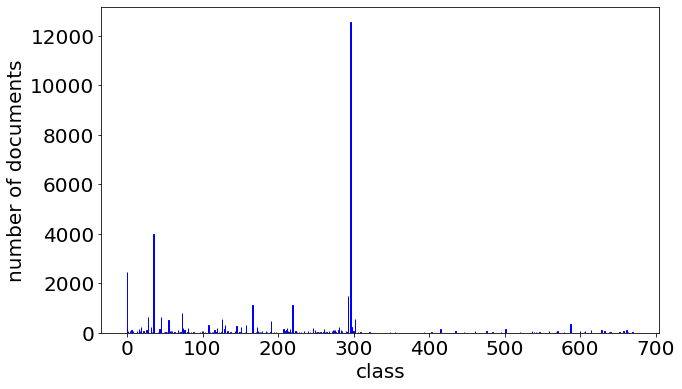

In [4]:
all_classes=range(0,len(classes_df['number_of_documents']))  # 672 classes in total
values = list(classes_df['number_of_documents'])

plt.figure(figsize=(10, 6))
plt.bar(list(all_classes), values, color ='maroon', width = 0.4,ec='blue')
plt.xlabel('class',fontsize=20)
plt.ylabel('number of documents',fontsize=20)
plt.show()

## Since the classes are imbalanced, we classify the documents to the ones that appear most of the time
## Top 20 classes appear in 72% of the documents

In [5]:
num_classes=20
classes_df_sorted=classes_df.sort_values(by='number_of_documents', ascending=False)
classes_df_sorted.head(num_classes)

,category,class,number_of_documents
296,Places,places_usa,12542
35,Topics,topics_earn,3987
0,Topics,topics_acq,2448
293,Places,places_uk,1489
219,Places,places_japan,1138
166,Places,places_canada,1104
73,Topics,topics_money-fx,801
28,Topics,topics_crude,634
45,Topics,topics_grain,628
302,Places,places_west-germany,567


(0.0, 1.0)

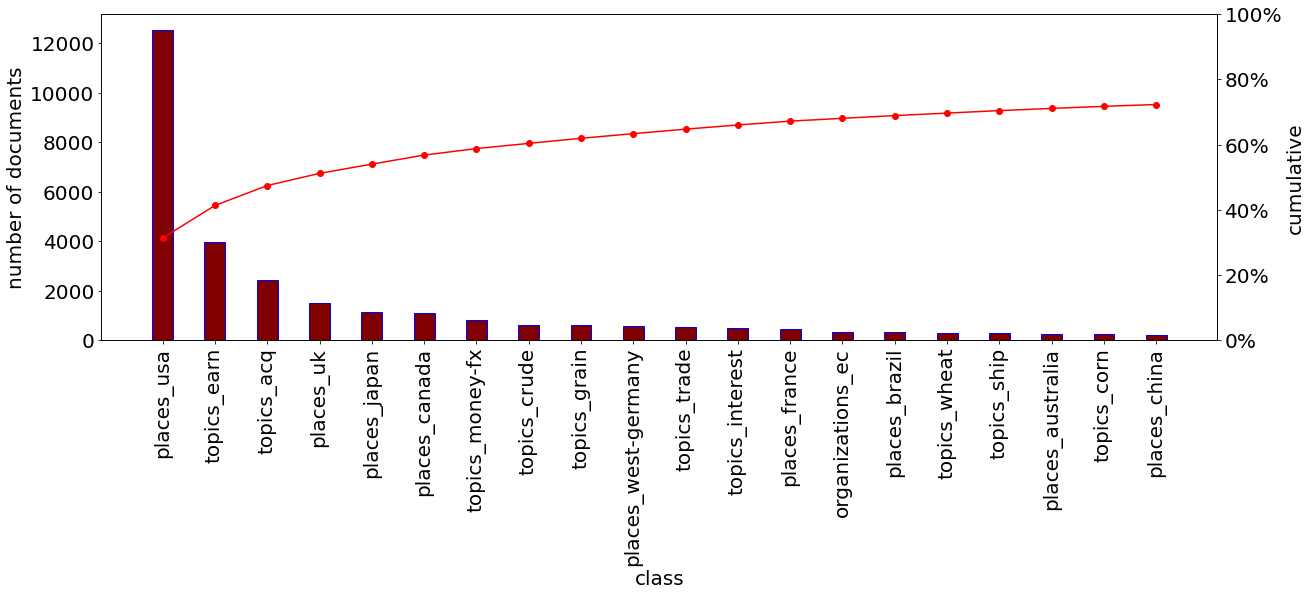

In [6]:
top_classes=range(0,len(classes_df_sorted['number_of_documents'][0:num_classes])) 
top_classes_names=list(classes_df_sorted['class'])[0:num_classes]

values = list(classes_df_sorted['number_of_documents'][0:num_classes])

fig,ax=plt.subplots(figsize=(20, 6))
ax.bar(list(top_classes), values, color ='maroon', width = 0.4,ec='blue')
ax.set_ylabel('number of documents')
ax.set_xlabel('class')
#ax.set_xticks(list(top_classes), top_classes_names)
#ax.set_xticklabels(top_classes_names,rotation=90)
plt.xticks(list(top_classes), top_classes_names, rotation=90)

ax2=ax.twinx()
ax2.plot(list(top_classes), np.cumsum(classes_df_sorted['number_of_documents'][0:num_classes])/np.sum(classes_df_sorted['number_of_documents']),'r-o') # I did not multiply by 100 because of the last command
ax2.set_ylabel('cumulative')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.set_ylim([0,1])
#ax2.set_xticklabels(top_classes_names,rotation=90)

# Clean the features by keeping alphanumeric values, doing lematization and removing stopwords

In [7]:
keep_alphanumeric_chars = re.compile("[^A-Za-z0-9 ]+")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean(r):
    r = r.lower().replace("<br />", " ")
    r = re.sub(keep_alphanumeric_chars, "", r.lower())
    
    words = word_tokenize(r)
    clean_sequence = []
    for word in words:
        # lematize
        word = lemmatizer.lemmatize(word)
        
        # remove stop words
        if word not in stop_words:
            clean_sequence.append(word)
    return " ".join(clean_sequence)


### Features and classes for a specific document

In [8]:
mmm=210
print(clean(doc_X[mmm]))
print()
print(doc_Y[mmm])

houston oil ho reserve study completed houston feb 26 houston oil trust said independentpetroleum engineer completed annual study estimatesthe trust future net revenue total proved reserve at88 mln dlrs discounted present value reserve at64 mln dlrs based estimate trust said may moneyavailable cash distribution unitholders theremainder year said estimate reflect decrease 44 pct innet reserve revenue 39 pct discounted present valuecompared study made 1985

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
X = []
for i, doc in enumerate(doc_X):
    X.append(clean(doc))
    
Y = np.array(doc_Y)

# Maximum document length 

In [10]:
document_length = [len(word_tokenize(x)) for x in X]
sorted_document_length=sorted(document_length)
max_document_length = sorted_document_length[-1]
print("maximum document length: ",max_document_length)

maximum document length:  1499


# Choose as document length the one that 90% of the documents have

90.0% of documents have maximum length  177


(0.0, 1.0)

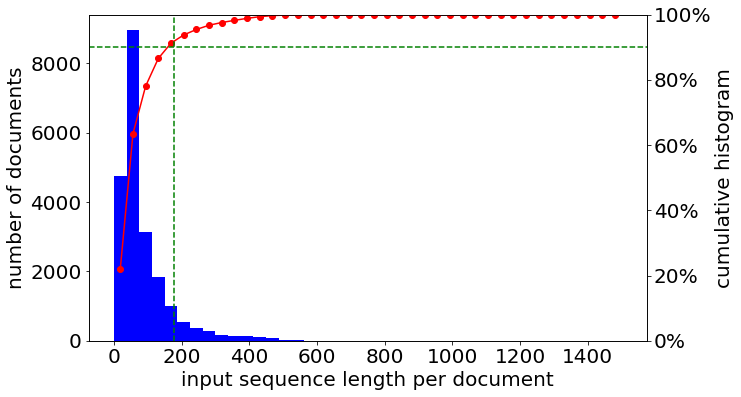

In [11]:
percent_=0.9
max_document_length = sorted_document_length[int(len(sorted_document_length) * percent_)]
print(str(percent_*100)+"% of documents have maximum length ",max_document_length)

fig,ax=plt.subplots(figsize=(10, 6))
counts, bins, _ = ax.hist(sorted_document_length,color='b', bins=40)
bin_centers = 0.5*(bins[1:] + bins[:-1])

ax.set_xlabel('input sequence length per document')
ax.set_ylabel('number of documents')
ax2=ax.twinx()
ax2.plot(bin_centers,np.cumsum(counts)/np.sum(counts),'r-o') # I did not multiply by 100 because of the last command
ax2.set_ylabel('cumulative histogram')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.axhline(y=percent_,color='g',linestyle='--')
ax2.axvline(x=max_document_length,color='g',linestyle='--')

ax2.set_ylim([0,1])
# ax2.set_xlim([0,100])
# ax.set_xlim([0,100])

# Tokenize the words

In [12]:
total_words=[]
for kkk in range(len(X)):
    words_per_doc=X[kkk].split()
    total_words.extend(words_per_doc)
    
num_unique_words=len(np.unique(total_words))
print('number of unique words:',num_unique_words)

max_vocab_size = num_unique_words
tokenizer = Tokenizer(max_vocab_size)
tokenizer.fit_on_texts(X)
input_vocab_size = len(tokenizer.word_index) + 1 
# +1 Because tokenizer.word_index is a python dictionary that contains token keys (string) and token ID values (integer), 
# and where the first token ID is 1 (not zero) and where the token IDs are assigned incrementally. 
# Therefore, the greatest token ID in word_index is len(word_index). 
# Therefore, we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID.
print("input_vocab_size:",input_vocab_size)

number of unique words: 173187
input_vocab_size: 173188


# Pad each document sentence so all of them have the same length 

In [13]:
X = np.array(pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_document_length, padding='post'))

# Model
###  Since we have a multi-class, multi-label classification, the probability of each class is independent of the probability of the others. So we will use the sigmoid activation fucntion at the final layer and binary cross entropy loss function

In [14]:
hidden_units=256

embedding_dim = 256
model = Sequential()
model.add(Embedding(input_vocab_size, embedding_dim,input_length = max_document_length))
model.add(GRU(hidden_units, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(hidden_units))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-05-02 03:15:26.780668: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-02 03:15:26.809568: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3393265000 Hz
2022-05-02 03:15:26.811292: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ea27f7b230 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-02 03:15:26.811334: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-02 03:15:26.920887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 03:15:26.921988: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ea27f830e0 initialized for platform CUDA (this does not guarantee that XLA 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 177, 256)          44336128  
_________________________________________________________________
gru_1 (GRU)                  (None, 177, 256)          393984    
_________________________________________________________________
dropout_1 (Dropout)          (None, 177, 256)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 45,129,236
Trainable params: 45,129,236
Non-trainable params: 0
__________________________________________

# Train the model, plot train and validation loss/accuracy and choose the model which corresponds to the smallest validation loss

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

num_epochs=40

checkpoint_name='best_checkpoint_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.hdf5'
model_checkpoint_callback = ModelCheckpoint(
     filepath=checkpoint_name,
     save_weights_only=True,
     monitor='val_loss',
     mode='min',
     save_best_only=True)
    
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=128, 
                    epochs=num_epochs, callbacks=[model_checkpoint_callback])

modelname = 'weights_at_last_epoch_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.hdf5'
model.save_weights(modelname)

/home/vgkortsas/.conda/envs/VOI/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15535 samples, validate on 1727 samples
Epoch 1/40


2022-05-02 03:15:29.136468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


15535/15535 [==============================] - 33s 2ms/step - loss: 0.2233 - accuracy: 0.9312 - val_loss: 0.1756 - val_accuracy: 0.9424
Epoch 2/40
15535/15535 [==============================] - 33s 2ms/step - loss: 0.1616 - accuracy: 0.9532 - val_loss: 0.1297 - val_accuracy: 0.9633
Epoch 3/40
15535/15535 [==============================] - 33s 2ms/step - loss: 0.1241 - accuracy: 0.9645 - val_loss: 0.1055 - val_accuracy: 0.9689
Epoch 4/40
15535/15535 [==============================] - 32s 2ms/step - loss: 0.0926 - accuracy: 0.9725 - val_loss: 0.0863 - val_accuracy: 0.9739
Epoch 5/40
15535/15535 [==============================] - 33s 2ms/step - loss: 0.0677 - accuracy: 0.9789 - val_loss: 0.0784 - val_accuracy: 0.9761
Epoch 6/40
15535/15535 [==============================] - 33s 2ms/step - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0689 - val_accuracy: 0.9782
Epoch 7/40
15535/15535 [==============================] - 33s 2ms/step - loss: 0.0361 - accuracy: 0.9882 - val_loss: 0.0690 - val

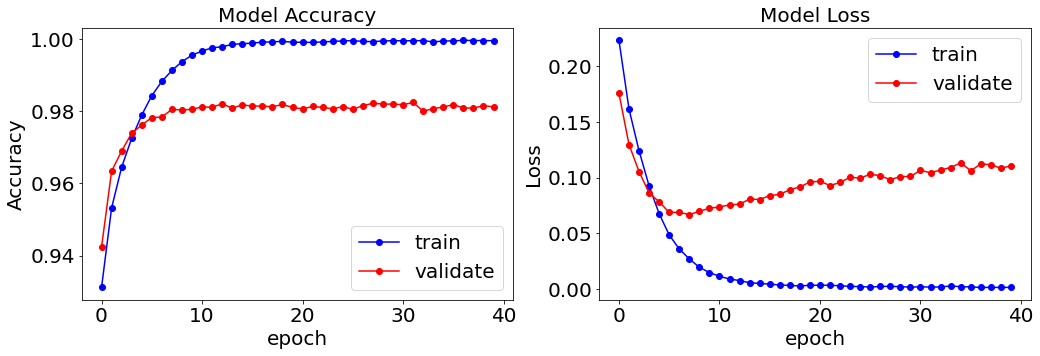

In [16]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'b-o') 
plt.plot(history.history['val_accuracy'],'r-o') 
plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20) 
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validate'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b-o') 
plt.plot(history.history['val_loss'],'r-o') 
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20) 
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validate'], loc='upper right')


plt.savefig('losses_'+str(ver)+ '_' + str(hidden_units)+ '_' + str(num_epochs) + '.png')
plt.show()

# save file
dict_losses = {'accuracy' : history.history['accuracy'], 'val_accuracy': history.history['val_accuracy'], 
               'loss' :history.history['loss'], 'val_loss' :history.history['val_loss']}
f = open('dict_losses_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.txt',"w")
f.write( str(dict_losses) )
f.close()

In [18]:
def plot_confusion_matrix_(cm, classes,
                          normalize=None,
                          title=None,
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=14)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
                   
    fmt = '.2f' if normalize else 'd'       
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    
def plot_confusion_matrices(Y_pred, Y_test, normalize=None):

    mcm=multilabel_confusion_matrix(Y_test,Y_pred)
    
    plt.figure(figsize=(20, 10))

    #conf_mat_dict=create_conf_mat_dict(Y_pred, Y_test)

    for kkk in range(len(selected_classes)):
        #cf=conf_mat_dict[selected_classes[kkk]]
        #conf_mat=reshape_confusion_matrix(cf)
        
        conf_mat=np.zeros((2,2),dtype=int)
        conf_mat[0][0]=mcm[kkk][1][1]
        conf_mat[0][1]=mcm[kkk][1][0]
        conf_mat[1][0]=mcm[kkk][0][1]
        conf_mat[1][1]=mcm[kkk][0][0]
        
        plt.subplot(4,5,kkk+1)
        plot_confusion_matrix_(conf_mat,classes=['True', 'False'], normalize=normalize, title=selected_classes[kkk])
        plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.3, 
                    hspace=0.4)
    
        if kkk>=15 and kkk<=19:
            plt.xlabel('predicted',fontsize=20)
        
        if kkk%5==0:
            plt.ylabel('actual',fontsize=20)
        
    plt.show()

## Since the classes are imbalanced, accuracy is not the best metric to evaluate the model on test data. Thus, we calculate precision, recall and F1 score

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.load_weights(checkpoint_name)
Y_pred=model.predict(X_test)

# convert Y_pred to 0 and 1
Y_pred_0_1=np.zeros(Y_pred.shape)
for kkk in range(len(Y_pred_0_1)):
    Y_pred_0_1[kkk]=(Y_pred[kkk]>0.5).astype(int) # we use 0.5 as the threshold
    
precision=precision_score(Y_test,Y_pred_0_1,average='micro')
recall=recall_score(Y_test,Y_pred_0_1,average='micro')
f1=f1_score(Y_test,Y_pred_0_1,average='micro')

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-measure: {:.4f}'.format(f1))


# save file
dict_scores = {'Precision' : precision, 'Recall': recall, 'F1-measure' :f1}
f = open('dict_scores_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.txt',"w")
f.write( str(dict_scores) )
f.close()


Precision: 0.8829
Recall: 0.8428
F1-measure: 0.8624


In [20]:
print(classification_report(Y_test, Y_pred_0_1, target_names=selected_classes))

                     precision    recall  f1-score   support

         places_usa       0.93      0.94      0.94      2554
        topics_earn       0.91      0.88      0.89       811
         topics_acq       0.78      0.78      0.78       485
          places_uk       0.80      0.78      0.79       274
       places_japan       0.84      0.81      0.82       216
      places_canada       0.86      0.83      0.85       230
    topics_money-fx       0.76      0.61      0.68       151
       topics_crude       0.87      0.65      0.74       131
       topics_grain       0.83      0.90      0.86       134
places_west-germany       0.83      0.61      0.70       116
       topics_trade       0.64      0.61      0.62        87
    topics_interest       0.80      0.45      0.57        87
      places_france       0.76      0.73      0.74       102
   organizations_ec       0.88      0.85      0.86        67
      places_brazil       0.85      0.46      0.59        72
       topics_wheat    

/home/vgkortsas/.conda/envs/VOI/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vgkortsas/.conda/envs/VOI/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


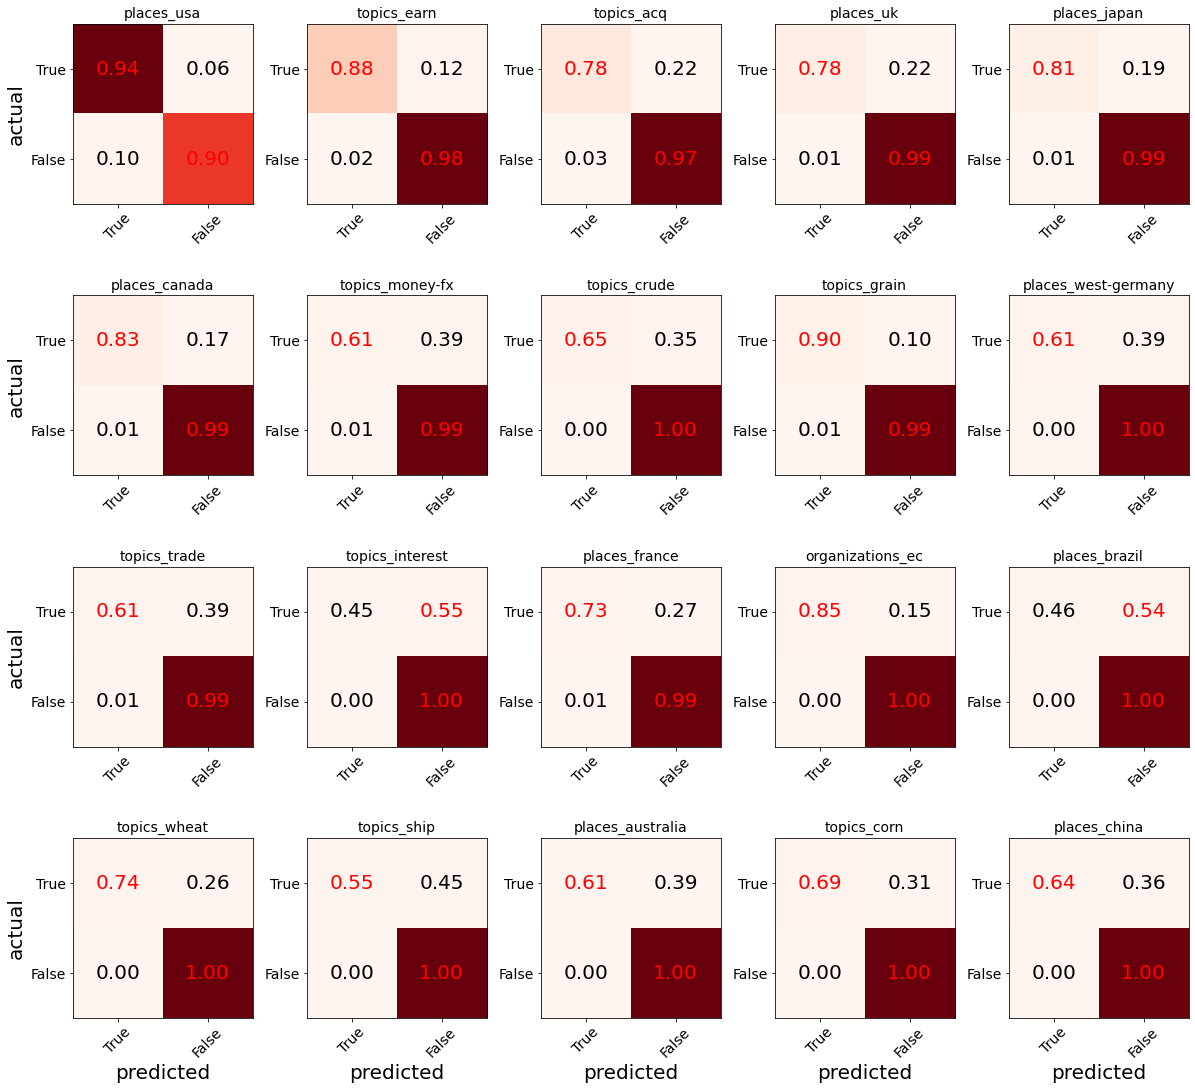

In [21]:
plot_confusion_matrices(Y_pred_0_1, Y_test, normalize=True)